In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from math import sqrt
import random
import os

<h2>Dataset</h2>

In [2]:
class CustomDataset(Dataset):
    """
    A custom dataset class for loading data from a CSV file.

    Args:
        csv_file (str): Path to the CSV file containing image filenames and scores.
        root_dir (str): Root directory containing the image files.
        transform (callable, optional): Optional transform to be applied to the images.

    Attributes:
        data (pandas.DataFrame): DataFrame containing the data loaded from the CSV file.
        root_dir (str): Root directory containing the image files.
        transform (callable, optional): Optional transform to be applied to the images.
    """
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name)
        scores = np.hstack(self.data.iloc[idx, 1:].values).astype(np.float32)
        scores = torch.from_numpy(scores)
        if self.transform:
            image = self.transform(image)
        return image, scores

In [3]:
test_loader = torch.load('test_loader.pt')
test_dataset = test_loader.dataset

<h2>Models</h2>

In [4]:
class ResnetsRegressionModel(nn.Module):
    """
    A regression model based on ResNets architecture.

    Args:
        backbone (str): The ResNet backbone type, e.g., "resnet18", "resnet34", or "resnet50".
        pretrained (bool): Whether to load pretrained weights. Default is True.
    """
    def __init__(self, backbone, pretrained=True):
        super(ResnetsRegressionModel, self).__init__()
        # Load pre-trained resnets model
        self.backbone = backbone
        if backbone == "resnet18":
            self.model = models.resnet18(pretrained=pretrained)
        elif backbone == "resnet34":
            self.model = models.resnet34(pretrained=pretrained)
        elif backbone == "resnet50":
            self.model = models.resnet50(pretrained=pretrained)

        # Freeze the parameters so they are not updated during training
        for param in self.model.parameters():
            param.requires_grad = False
        # Modify the last fully connected layer for regression
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        return self.model(x)


class EfficientnetsRegressionModel(nn.Module):
    """
    A regression model based on EfficientNets architecture.

    Args:
        backbone (str): The EfficientNet backbone type, e.g., "efficientnet_b0", "efficientnet_b1", "efficientnet_b2", or "efficientnet_b3".
        pretrained (bool): Whether to load pretrained weights. Default is True.
    """
    def __init__(self, backbone, pretrained=True):
        super(EfficientnetsRegressionModel, self).__init__()
        # Load pre-trained model
        self.backbone = backbone
        if backbone == "efficientnet_b0":
            self.model = models.efficientnet_b0(pretrained=pretrained)
        elif backbone == "efficientnet_b1":
            self.model = models.efficientnet_b1(pretrained=pretrained)
        elif backbone == "efficientnet_b2":
            self.model = models.efficientnet_b2(pretrained=pretrained)
        elif backbone == "efficientnet_b3":
            self.model = models.efficientnet_b3(pretrained=pretrained)

        # Freeze the parameters so they are not updated during training
        for param in self.model.parameters():
            param.requires_grad = False

        # Modify the last classifier for regression
        self.model.classifier = nn.Sequential(
            nn.Linear(self.model.classifier[1].in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        return self.model(x)


class InceptionRegressionModel(nn.Module):
    """
    A regression model based on InceptionV3 architecture.

    Args:
        pretrained (bool): Whether to load pretrained weights. Default is True.
    """
    def __init__(self, pretrained=True):
        super(InceptionRegressionModel, self).__init__()
        # Load pre-trained model
        self.backbone = "inception_v3"
        self.model = models.googlenet(pretrained=pretrained)
        # Freeze the parameters so they are not updated during training
        for param in self.model.parameters():
            param.requires_grad = False
        # Modify the last fully connected layer for regression
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        return self.model(x)


class VisionTransformersRegressionModel(nn.Module):
    """
    A regression model based on Vision Transformers architecture.

    Args:
        backbone (str): The Vision Transformer backbone type, e.g., "vit_b_16" or "vit_h_14".
        pretrained (bool): Whether to load pretrained weights. Default is True.
    """
    def __init__(self, backbone, pretrained=True):
        super(VisionTransformersRegressionModel, self).__init__()
        # Load pre-trained model
        self.backbone = backbone
        if backbone == "vit_b_16":
            self.model = models.vit_b_16(pretrained=pretrained)

        elif backbone == "vit_h_14":
            self.model = models.vit_h_14(pretrained=pretrained)

        # Freeze the parameters so they are not updated during training
        for param in self.model.parameters():
            param.requires_grad = False
        # Modify the last fully connected layer for regression
        self.model.heads = nn.Sequential(
            nn.Linear(self.model.heads.head.in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 2),  # Output 2 values for regression
            nn.Sigmoid()  # Sigmoid activation to ensure values between 0 and 1
        )

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        return self.model(x)


def get_model(backbone):
    """
    Get the regression model based on the specified backbone.

    Args:
        backbone (str): The backbone type of the model.

    Returns:
        nn.Module: The regression model.
    """
    if backbone in ["resnet18", "resnet34", "resnet50"]:
        return ResnetsRegressionModel(backbone)

    elif backbone in ["efficientnet_b0", "efficientnet_b1", "efficientnet_b2", "efficientnet_b3"]:
        return EfficientnetsRegressionModel(backbone)

    elif backbone == "inception_v3":
        return InceptionRegressionModel()

    elif backbone in ["vit_b_16", "vit_h_14"]:
        return VisionTransformersRegressionModel(backbone)

    else:
        return
    
def load_model(checkpoint, backbone):
    """
    Load a pre-trained model from a checkpoint file.

    Args:
        checkpoint (str): Path to the checkpoint file containing model parameters.
        backbone (str): The backbone architecture of the model.

    Returns:
        torch.nn.Module: The loaded model.
    """
    model = get_model(backbone)
    model.load_state_dict(torch.load(checkpoint))
    return model 

<h2>Predict</h2>

In [5]:
def predict(model, criterion, dataloader):
    """
    Predict outputs using a trained model and calculate test metrics.

    Args:
        model (torch.nn.Module): The trained model for prediction.
        criterion: The loss function (e.g., torch.nn.MSELoss).
        dataloader (torch.utils.data.DataLoader): DataLoader for the test dataset.

    Returns:
        tuple: A tuple containing test losses, test labels, and test predictions.
    """
    test_losses = []
    test_predictions_all = []
    test_labels_all = []

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            outputs = model(inputs)
            test_loss = criterion(outputs, labels).item()
            test_losses.append(test_loss)
            test_predictions_all.extend(outputs.numpy())
            test_labels_all.extend(labels.numpy())
    
    # Calculate test metrics
    test_losses = np.array(test_losses)
    test_predictions_all = np.array(test_predictions_all)
    test_labels_all = np.array(test_labels_all)
    test_mse = mean_squared_error(test_labels_all, test_predictions_all)
    test_mae = mean_absolute_error(test_labels_all, test_predictions_all)
    test_rmse = sqrt(test_mse)
    test_r2 = r2_score(test_labels_all, test_predictions_all)
    print('Test Loss: %.3f, MSE: %.3f, MAE: %.3f, RMSE: %.3f, R-squared: %.3f' %
          (np.mean(test_losses), test_mse, test_mae, test_rmse, test_r2))
    
    return test_losses, test_labels_all, test_predictions_all

<h2>Evaluation</h2>
<h3>Quantitative evaluation</h3>

In [6]:
# Randomly select 10 images from the test set
random_indices = random.sample(range(len(test_loader.dataset)), 10)

In [7]:
criterion = nn.MSELoss()
resnet18_best_model = load_model("../training/resnet18/models/resnet18_best_model.pth", "resnet18")

/Users/nsbaa/Desktop/long-covid-venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nsbaa/Desktop/long-covid-venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
test_losses, test_labels_all, test_predictions_all = predict(resnet18_best_model, criterion, test_loader)

Test Loss: 0.036, MSE: 0.036, MAE: 0.121, RMSE: 0.189, R-squared: 0.747


<h3> Analyze the performance metrics:</h3>

<ul>
  <li><b>Mean Squared Error (MSE):</b> MSE measures the average of the squares of the errors, which indicates how close the predicted values are to the actual values. In this case, the MSE is 0.036, which means that, on average, the squared difference between predicted and actual values is 0.036. A lower MSE indicates better performance.</li>
  <li><b>Mean Absolute Error (MAE): </b>MAE measures the average absolute difference between the predicted and actual values. Here, the MAE is 0.121, indicating that, on average, the predicted values differ by 0.121 from the actual values. A lower MAE indicates better performance.</li>
  <li><b>Root Mean Squared Error (RMSE):</b>RMSE is the square root of the MSE, which provides a measure of the spread of the errors. The RMSE here is 0.189, which indicates the average magnitude of the errors in the predicted values. As with MSE, a lower RMSE is preferable.</li>
  <li><b>R-squared (R²): </b>  R-squared is a measure of how well the predicted values fit the actual values. It ranges from 0 to 1, with 1 indicating a perfect fit. Here, the R-squared value is 0.747, which means that approximately 74.7% of the variance in the actual values is explained by the predicted values. A higher R-squared value indicates better performance.</li>
</ul>

The regression model seems to perform reasonably well. The MSE, MAE, and RMSE are relatively low, indicating that the model's predictions are close to the actual values. Additionally, the R-squared value of 0.747 indicates a good fit between predicted and actual values, suggesting that the model captures a significant portion of the variance in the data.

<h3>Qualitative evaluation</h3>
<h4>Visualization:</h4>

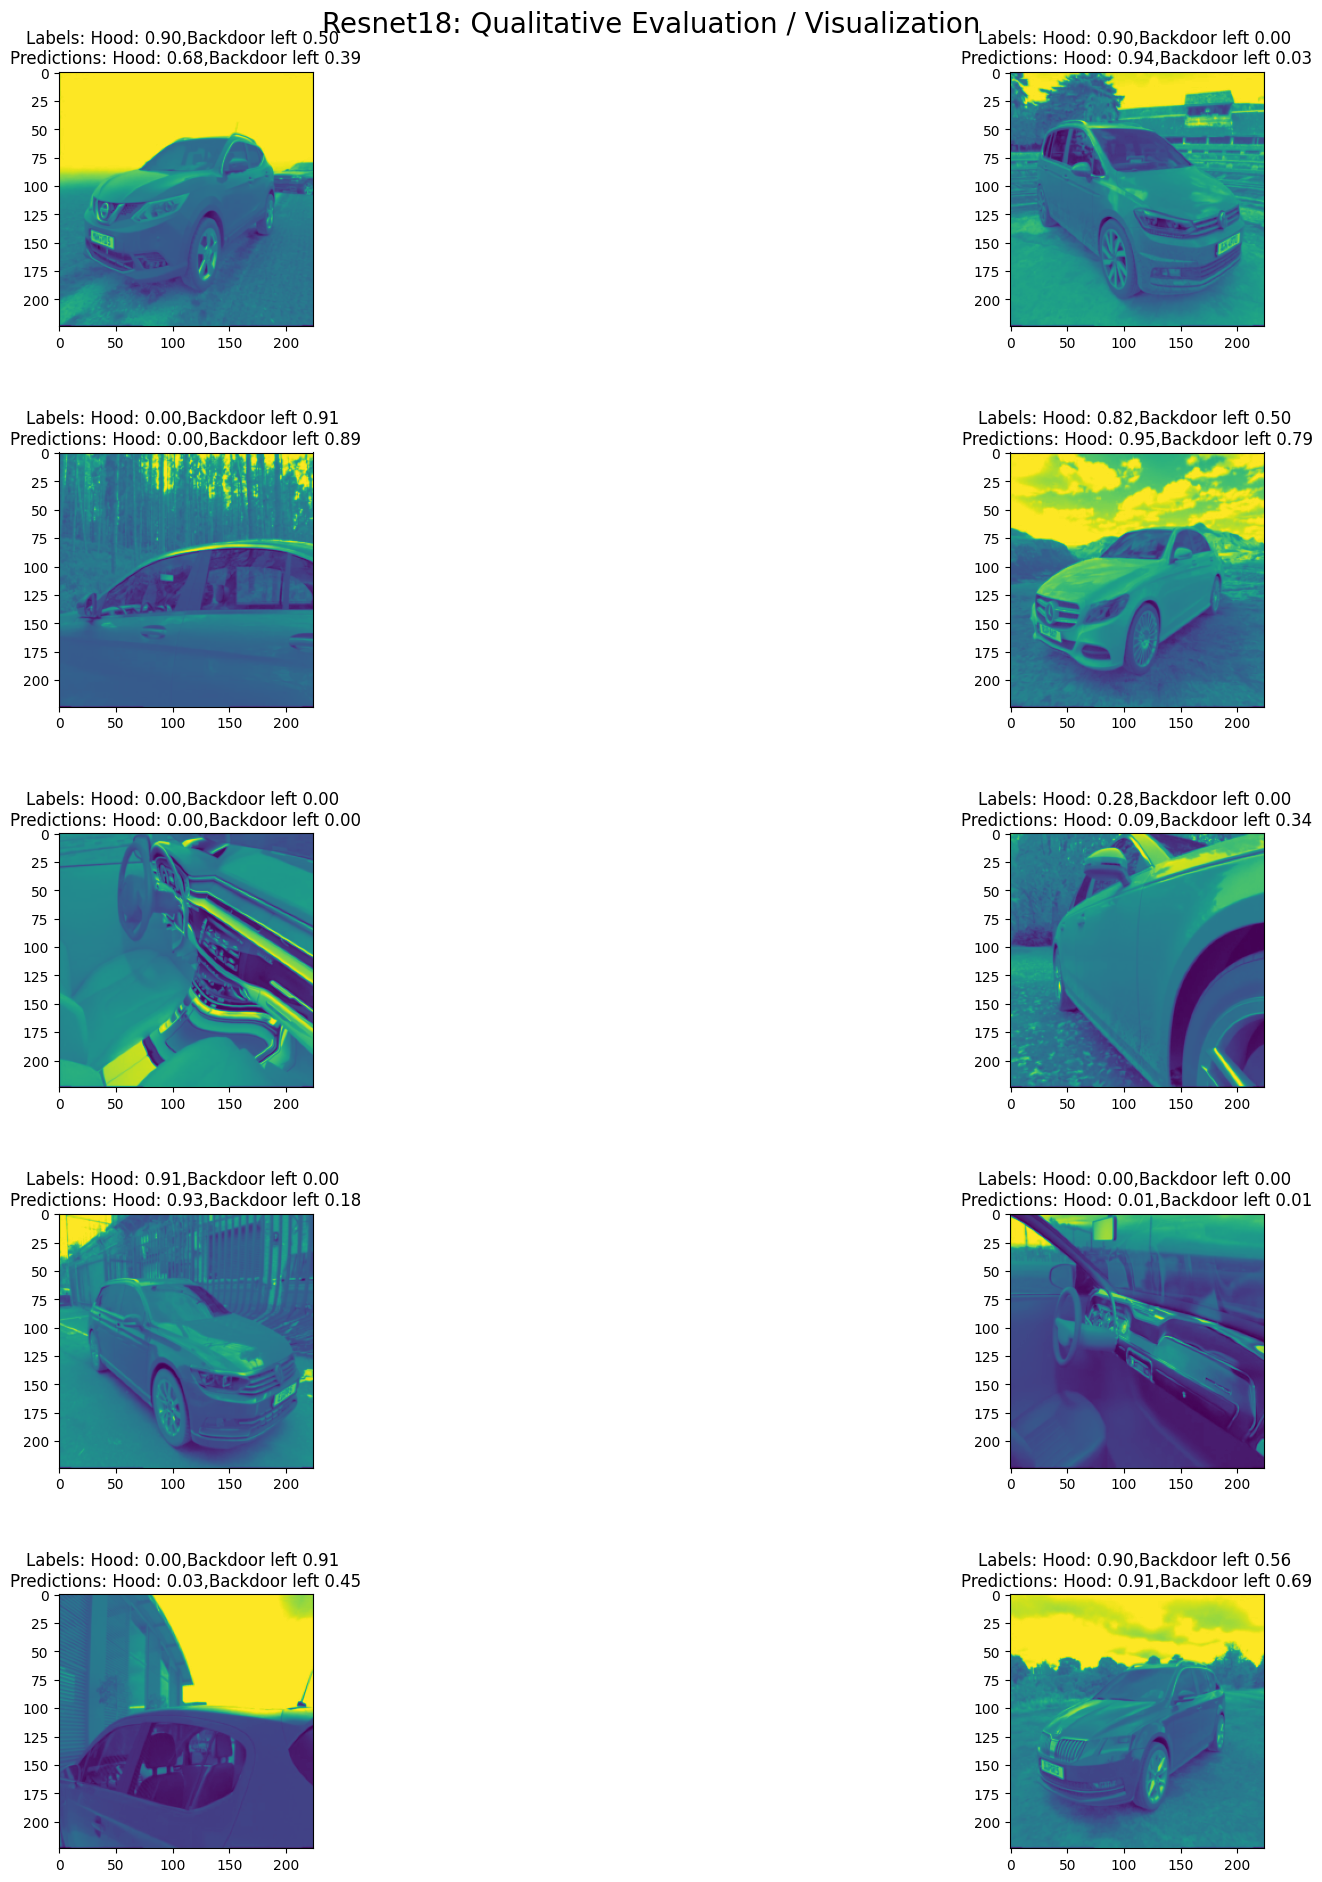

In [9]:
fig, axes = plt.subplots(5, 2, figsize=(20, 20))
fig.tight_layout(pad=7.0) # Or equivalently,  "plt.tight_layout()"
fig.suptitle('Resnet18: Qualitative Evaluation / Visualization', fontsize=20)

i = 0
for oo in range(0,5):
    for ii in range(0, 2):
        index = random_indices[i]
        labels = test_labels_all[index]
        preds = test_predictions_all[index]
        title = 'Labels: Hood: %.2f,Backdoor left %.2f \nPredictions: Hood: %.2f,Backdoor left %.2f' % (labels[0], labels[1], preds[0], preds[1])
        image, label = test_dataset[index]
        axes[oo, ii].imshow(image[0])
        axes[oo, ii].set_title(title)
        i += 1
        
plt.show()

<h4>Distribution:</h4>

In [10]:
def count_images_per_perspective_data(data, mean_score_hood, mean_score_backdoor_left):
    """
    Count the number of images per perspective data category.

    Args:
        dataset: The dataset containing perspective score data.

    Returns:
        dict: A dictionary containing counts of images for each perspective category.
    """
    count_predictions = {
        'hood': 0,
        'backdoor_left': 0,
        'both': 0,
        'else': 0,
    }
        
    for scores in data:
        score_hood = scores[0]
        score_backdoor_left = scores[1]

        if score_hood == 0.0 and score_backdoor_left == 0.0: 
            count_predictions['else'] += 1

        elif score_hood > mean_score_hood and score_backdoor_left > mean_score_backdoor_left:
            count_predictions['both'] += 1

        elif score_hood > mean_score_hood:
            count_predictions['hood'] += 1

        else:
            count_predictions['backdoor_left'] += 1
    return count_predictions

In [11]:
test_mean_score_hood = np.array([test_labels[0] for test_labels in test_labels_all]).mean()
test_mean_score_backdoor_left = np.array([test_labels[1] for test_labels in test_labels_all]).mean()

In [12]:
count_images_labels = count_images_per_perspective_data(test_labels_all, test_mean_score_hood, test_mean_score_backdoor_left)

In [13]:
count_images_predictions = count_images_per_perspective_data(test_predictions_all, test_mean_score_hood, test_mean_score_backdoor_left)

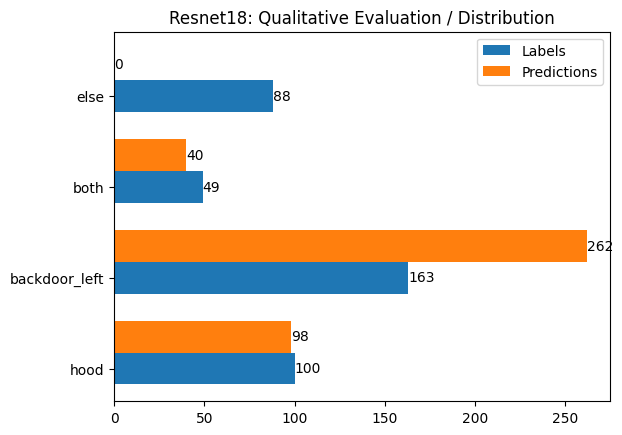

In [14]:
fig, ax = plt.subplots()

# Set width for each bar
bar_width = 0.35

# Create bars for the first set of counts
bars1 = ax.barh(range(len(count_images_labels)), count_images_labels.values(), bar_width, label='Labels')

# Create bars for the second set of counts
bars2 = ax.barh([x + bar_width for x in range(len(count_images_predictions))], count_images_predictions.values(), bar_width, label='Predictions')

# Set y ticks and labels
ax.set_yticks(range(len(count_images_labels)))
ax.set_yticklabels(count_images_labels.keys())

# Add labels to the bars
ax.bar_label(bars1)
ax.bar_label(bars2)

ax.set_title('Resnet18: Qualitative Evaluation / Distribution')

# Add legend
ax.legend()

plt.show()


<h4>Check for data drift</h4>

In [15]:
predictions_mean_score_hood = np.array([test_predictions[0] for test_predictions in test_predictions_all]).mean()
predictions_mean_score_backdoor_left = np.array([test_predictions[1] for test_predictions in test_predictions_all]).mean()

In [16]:
count_images_predictions = count_images_per_perspective_data(test_predictions_all, predictions_mean_score_hood, predictions_mean_score_backdoor_left)

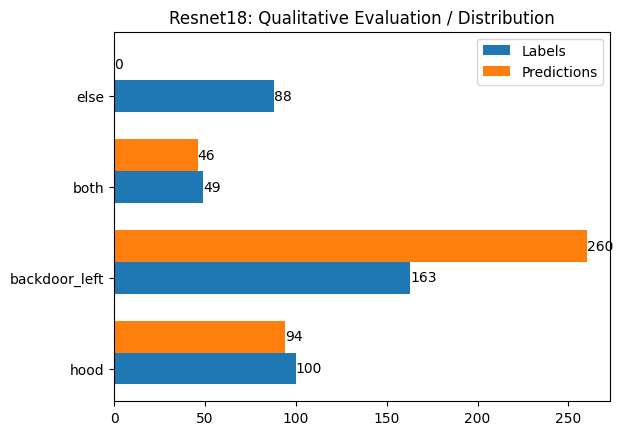

In [17]:
fig, ax = plt.subplots()

# Set width for each bar
bar_width = 0.35

# Create bars for the first set of counts
bars1 = ax.barh(range(len(count_images_labels)), count_images_labels.values(), bar_width, label='Labels')

# Create bars for the second set of counts
bars2 = ax.barh([x + bar_width for x in range(len(count_images_predictions))], count_images_predictions.values(), bar_width, label='Predictions')

# Set y ticks and labels
ax.set_yticks(range(len(count_images_labels)))
ax.set_yticklabels(count_images_labels.keys())

# Add labels to the bars
ax.bar_label(bars1)
ax.bar_label(bars2)

ax.set_title('Resnet18: Qualitative Evaluation / Distribution')

# Add legend
ax.legend()

plt.show()


In [18]:
print("count_images_labels", count_images_labels)
print("count_images_predictions", count_images_predictions)

count_images_labels {'hood': 100, 'backdoor_left': 163, 'both': 49, 'else': 88}
count_images_predictions {'hood': 94, 'backdoor_left': 260, 'both': 46, 'else': 0}



<h3> Analyzing predictions distribution </h3>
<ul>
  <li><b>Imbalance or Bias:</b>
The model predicts a significantly higher number of instances for the 'backdoor_left' class compared to other classes. This imbalance could indicate that the model may be biased towards predicting this class more frequently, potentially due to a bias in the training data or an inherent difficulty in distinguishing between classes.
    </li>
  <li><b>Class Distribution vs. Actual Distribution:</b>
Comparing the predicted class distribution with the actual class distribution can provide insights into whether the model captures the underlying patterns in the data. If the predicted distribution closely resembles the actual distribution, it indicates that the model is effectively capturing the characteristics of the data.
    </li>
  <li><b>Impact on Performance Metrics:</b>
The imbalance in class distribution can also affect performance metrics such as accuracy, precision, recall, and F1-score, especially in cases of class imbalance. 
    </li>
</ul>